In [2]:
import pandas as pd
final_df=pd.read_csv('../Dataset/final_df.csv')

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load geojson
gdf = gpd.read_file("../Dataset/GeoJSON/india_pincode.geojson")

In [4]:
enr_cols = [
    "enr_age_0_5",
    "enr_age_5_17",
    "enr_age_18_greater"
]

final_df[enr_cols] = (
    final_df[enr_cols]
    .apply(pd.to_numeric, errors="coerce")
    .fillna(0)
)

In [5]:
state_enrol = (
    final_df
    .groupby("state", as_index=False)[enr_cols]
    .sum()
)

# 0-5 Enrolment

In [6]:
top_0_5 = (
    state_enrol
    .sort_values("enr_age_0_5", ascending=False)
    .head(5)
)
top_0_5

,state,enr_age_0_5,enr_age_5_17,enr_age_18_greater
33,Uttar Pradesh,509959.0,469808.0,17851.0
19,Madhya Pradesh,373314.0,116282.0,9564.0
4,Bihar,260253.0,321636.0,10689.0
20,Maharashtra,259508.0,76421.0,8157.0
34,West Bengal,229547.0,70725.0,7263.0


In [7]:
india_states = gpd.read_file("../Dataset/GeoJSON/india_state_geo.json")

In [8]:
india_states["state_norm"] = (
    india_states["NAME_1"]
    .str.lower()
    .str.replace("&", "and")
    .str.replace(" islands", "", regex=False)
    .str.strip()
)

top_0_5["state_norm"] = (
    top_0_5["state"]
    .str.lower()
    .str.replace("&", "and")
    .str.replace(" islands", "", regex=False)
    .str.strip()
)

In [9]:
top_states_geo = india_states[
    india_states["state_norm"].isin(top_0_5["state_norm"])
]
top_states_geo[["NAME_1", "state_norm"]]



,NAME_1,state_norm
4,Bihar,bihar
19,Madhya Pradesh,madhya pradesh
20,Maharashtra,maharashtra
32,Uttar Pradesh,uttar pradesh
34,West Bengal,west bengal


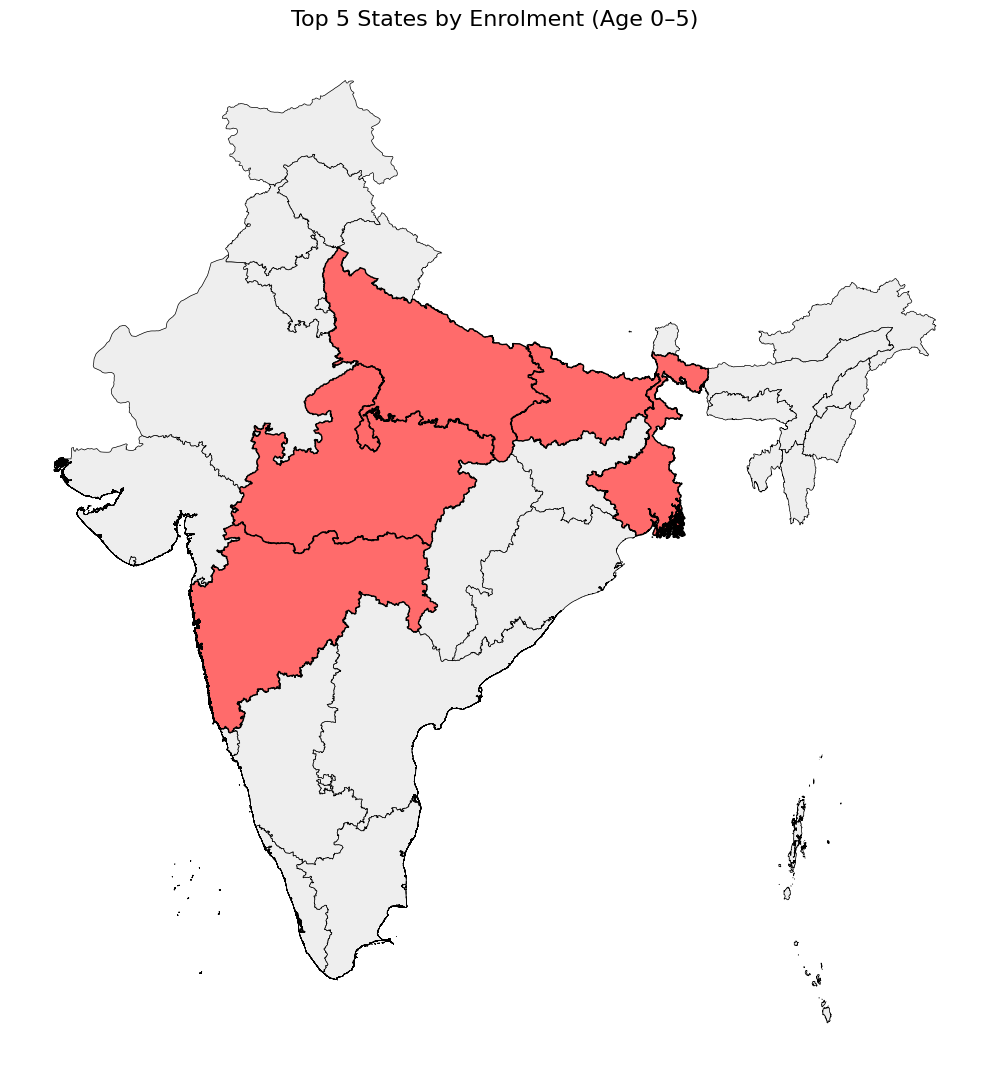

In [10]:
fig, ax = plt.subplots(figsize=(10, 12))

# Plot all states in light grey
india_states.plot(
    ax=ax,
    color="#eeeeee",
    edgecolor="black",
    linewidth=0.5
)

# Highlight top 5 states
top_states_geo.plot(
    ax=ax,
    color="#ff6b6b",
    edgecolor="black",
    linewidth=1
)

ax.set_title("Top 5 States by Enrolment (Age 0–5)", fontsize=16)
ax.axis("off")

plt.tight_layout()
plt.show()


# Uttar Pradesh Enrolment Status 0-5

In [11]:
up_df = final_df[final_df["state"] == "Uttar Pradesh"].copy()


In [66]:
top_districts = (
    up_df
    .groupby("district", as_index=False)["enr_age_0_5"]
    .sum()
    .sort_values("enr_age_0_5", ascending=False)
)

top_districts


,district,enr_age_0_5
14,Bareilly,17787.0
0,Agra,16974.0
70,Sitapur,16643.0
56,Moradabad,15659.0
9,Bahraich,15097.0
...,...,...
13,Barabanki,1423.0
6,Ayodhya,1046.0
68,Shravasti,867.0
16,Bhadohi,274.0


In [15]:
districts_gdf = gpd.read_file("../Dataset/GeoJSON/india_district.geojson")

In [16]:
districts_gdf["state_norm"] = (
    districts_gdf["NAME_1"]
    .str.lower()
    .str.replace("&", "and")
    .str.strip()
)

up_districts_gdf = districts_gdf[
    districts_gdf["state_norm"] == "uttar pradesh"
].copy()


In [20]:
#District names normalization
def normalize_district(s):
    return (
        s.lower()
        .replace("&", "and")
        .replace(".", "")
        .replace(" district", "")
        .strip()
    )

up_districts_gdf["district_norm"] = (
    up_districts_gdf["NAME_2"].apply(normalize_district)
)

top_districts["district_norm"] = (
    top_districts["district"].apply(normalize_district)
)


In [41]:
gdf = up_districts_gdf.merge(
    top_districts,
    on="district_norm",
    how="left"
)

# Replace NaN enrolment with 0
gdf["enr_age_0_5"] = gdf["enr_age_0_5"].fillna(0)


In [23]:
top5 = (
    gdf[["NAME_2", "enr_age_0_5"]]
    .sort_values("enr_age_0_5", ascending=False)
    .head(5)
    .reset_index(drop=True)
)

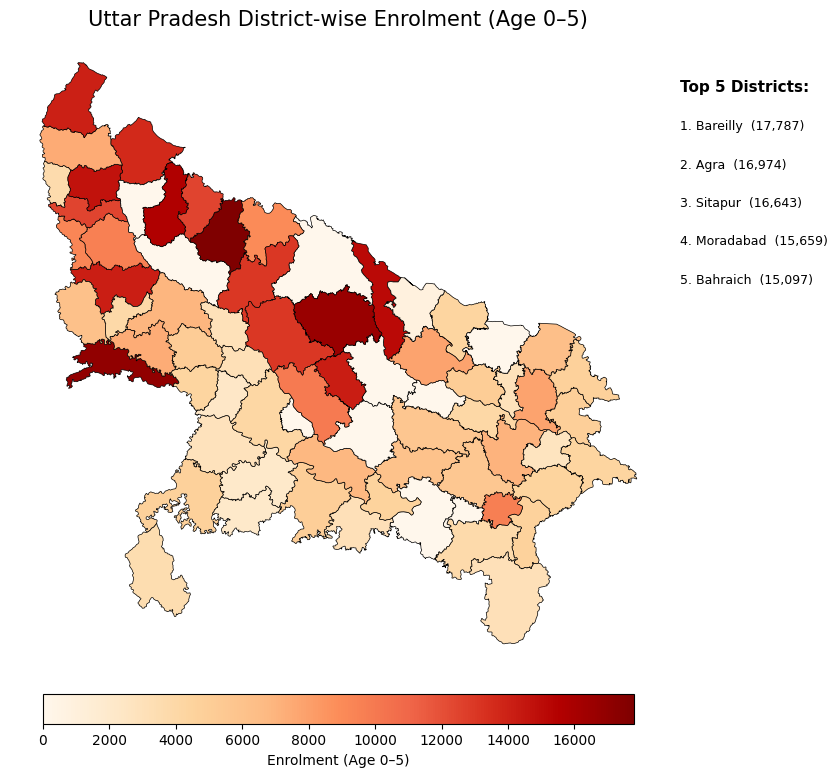

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12))

gdf.plot(
    ax=ax,
    column="enr_age_0_5",
    cmap="OrRd",          # light → dark
    linewidth=0.5,
    edgecolor="black",
    legend=True,
    legend_kwds={
    "label": "Enrolment (Age 0–5)",
    "orientation": "horizontal",
    "shrink": 0.9,
    "pad": 0.02
}
)

ax.set_title(
    "Uttar Pradesh District-wise Enrolment (Age 0–5)",
    fontsize=15
)
ax.axis("off")
x_pos = 1.02   # right of the map
y_start = 0.85
line_gap = 0.06

ax.text(
    x_pos, y_start + line_gap,
    "Top 5 Districts:",
    transform=ax.transAxes,
    fontsize=11,
    fontweight="bold",
    ha="left"
)

for i, row in top5.iterrows():
    ax.text(
        x_pos,
        y_start - i * line_gap,
        f"{i+1}. {row['NAME_2']}  ({int(row['enr_age_0_5']):,})",
        transform=ax.transAxes,
        fontsize=9,
        ha="left"
    )
plt.tight_layout(rect=[0, 0.08,0.85, 1])

plt.show()


In [50]:
bareilly_df = final_df[
    (final_df["state"] == "Uttar Pradesh") &
    (final_df["district"] == "Bareilly")
].copy()


In [52]:
import pandas as pd

bareilly_df["enr_age_0_5"] = pd.to_numeric(
    bareilly_df["enr_age_0_5"], errors="coerce"
).fillna(0)

pincode_enrol = (
    bareilly_df
    .groupby("pincode", as_index=False)["enr_age_0_5"]
    .sum()
)

# Ensure string for merge
pincode_enrol["pincode"] = pincode_enrol["pincode"].astype(str)

pincode_enrol


,pincode,enr_age_0_5
0,243001,2800.0
1,243002,6.0
2,243003,314.0
3,243004,3.0
4,243005,403.0
5,243006,277.0
6,243122,598.0
7,243123,555.0
8,243201,4143.0
9,243202,575.0


In [55]:
pin_code_gdf = gpd.read_file("../Dataset/GeoJSON/india_pincode.geojson")

In [57]:
# Ensure pincode column consistency
pin_code_gdf["Pincode"] = pin_code_gdf["Pincode"].astype(str).str.strip()

bareilly_gdf = pin_code_gdf.merge(
    pincode_enrol,
    left_on="Pincode",
    right_on="pincode",
    how="inner"
)


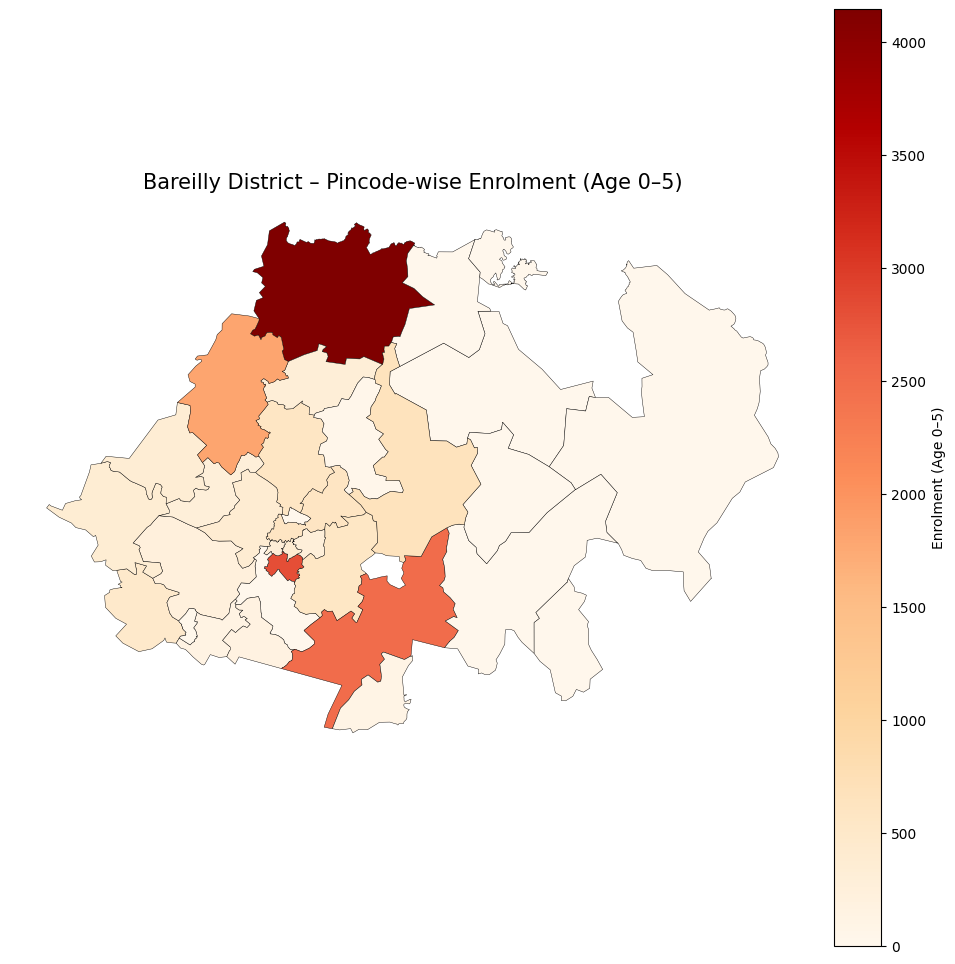

In [58]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12))

bareilly_gdf.plot(
    ax=ax,
    column="enr_age_0_5",
    cmap="OrRd",
    linewidth=0.3,
    edgecolor="black",
    legend=True,
    legend_kwds={
        "label": "Enrolment (Age 0–5)",
        "shrink": 0.8,
        "pad": 0.02
    }
)

ax.set_title(
    "Bareilly District – Pincode-wise Enrolment (Age 0–5)",
    fontsize=15
)
ax.axis("off")

plt.tight_layout()
plt.show()


# 5 - 17 Enrolment


In [59]:
top_5_17 = (
    state_enrol
    .sort_values("enr_age_5_17", ascending=False)
    .head(5)
)
top_5_17

,state,enr_age_0_5,enr_age_5_17,enr_age_18_greater
33,Uttar Pradesh,509959.0,469808.0,17851.0
4,Bihar,260253.0,321636.0,10689.0
19,Madhya Pradesh,373314.0,116282.0,9564.0
28,Rajasthan,180285.0,90601.0,3749.0
20,Maharashtra,259508.0,76421.0,8157.0


In [60]:
india_states["state_norm"] = (
    india_states["NAME_1"]
    .str.lower()
    .str.replace("&", "and")
    .str.replace(" islands", "", regex=False)
    .str.strip()
)

top_5_17["state_norm"] = (
    top_5_17["state"]
    .str.lower()
    .str.replace("&", "and")
    .str.replace(" islands", "", regex=False)
    .str.strip()
)

In [63]:
top_states_geo = india_states[
    india_states["state_norm"].isin(top_5_17["state_norm"])
]
top_states_geo[["NAME_1", "state_norm"]]



,NAME_1,state_norm
4,Bihar,bihar
19,Madhya Pradesh,madhya pradesh
20,Maharashtra,maharashtra
28,Rajasthan,rajasthan
32,Uttar Pradesh,uttar pradesh


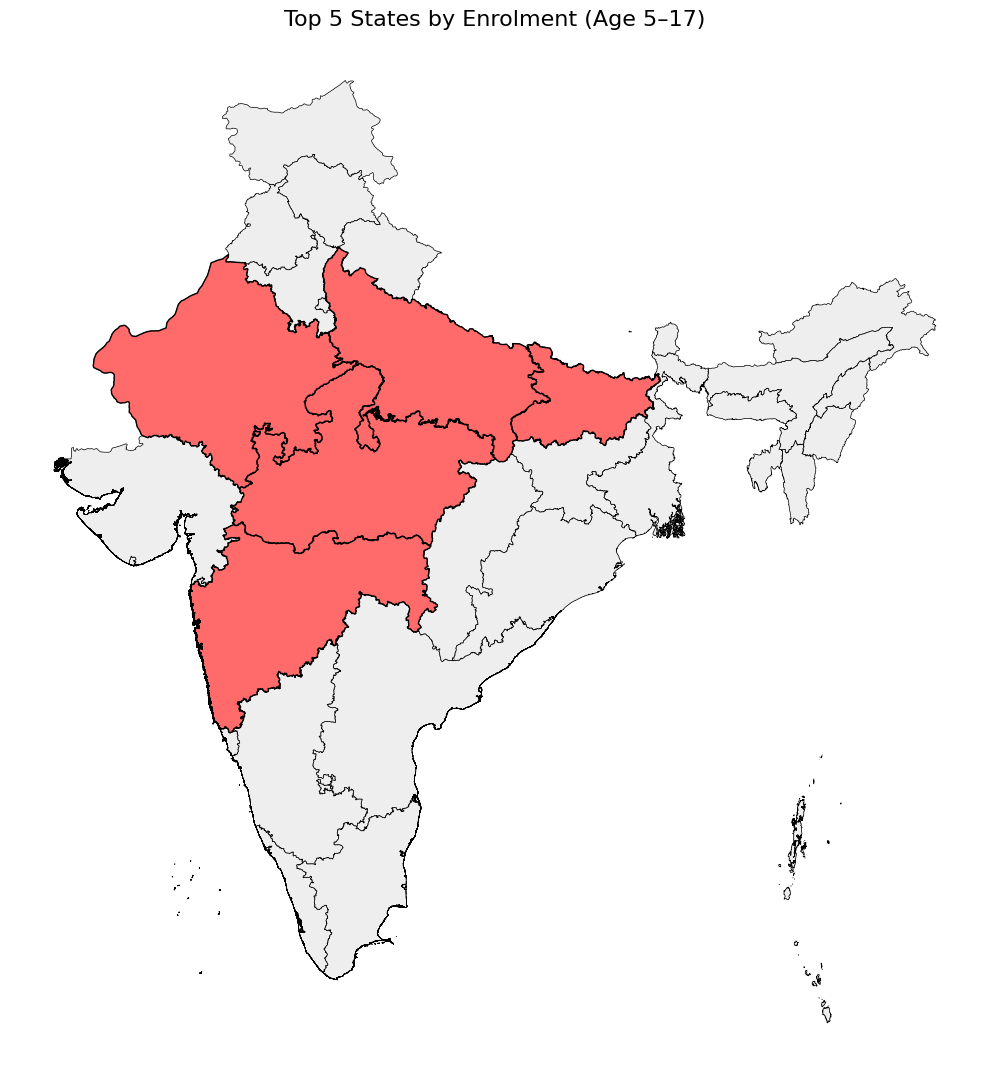

In [64]:
fig, ax = plt.subplots(figsize=(10, 12))

# Plot all states in light grey
india_states.plot(
    ax=ax,
    color="#eeeeee",
    edgecolor="black",
    linewidth=0.5
)

# Highlight top 5 states
top_states_geo.plot(
    ax=ax,
    color="#ff6b6b",
    edgecolor="black",
    linewidth=1
)

ax.set_title("Top 5 States by Enrolment (Age 5–17)", fontsize=16)
ax.axis("off")

plt.tight_layout()
plt.show()


# Uttar Pradesh Enrolment Status 5-17   

In [94]:
top_districts_5_17 = (
    up_df
    .groupby("district", as_index=False)["enr_age_5_17"]
    .sum()
    .sort_values("enr_age_5_17", ascending=False)
)

top_districts_5_17


,district,enr_age_5_17
9,Bahraich,22927.0
70,Sitapur,14167.0
7,Azamgarh,14096.0
74,Varanasi,13669.0
45,Kheri,13241.0
...,...,...
50,Mahoba,1080.0
13,Barabanki,942.0
6,Ayodhya,646.0
16,Bhadohi,288.0


In [95]:
def normalize_district(s):
    return (
        s.lower()
        .replace("&", "and")
        .replace(".", "")
        .replace(" district", "")
        .strip()
    )

up_districts_gdf["district_norm"] = (
    up_districts_gdf["NAME_2"].apply(normalize_district)
)

top_districts_5_17["district_norm"] = (
    top_districts_5_17["district"].apply(normalize_district)
)

In [96]:
gdf = up_districts_gdf.merge(
    top_districts_5_17,
    on="district_norm",
    how="left"
)

# Replace NaN enrolment with 0
gdf["enr_age_5_17"] = gdf["enr_age_5_17"].fillna(0)


In [97]:
top5_5_17 = (
    gdf[["NAME_2", "enr_age_5_17"]]
    .sort_values("enr_age_5_17", ascending=False)
    .head(5)
    .reset_index(drop=True)
)

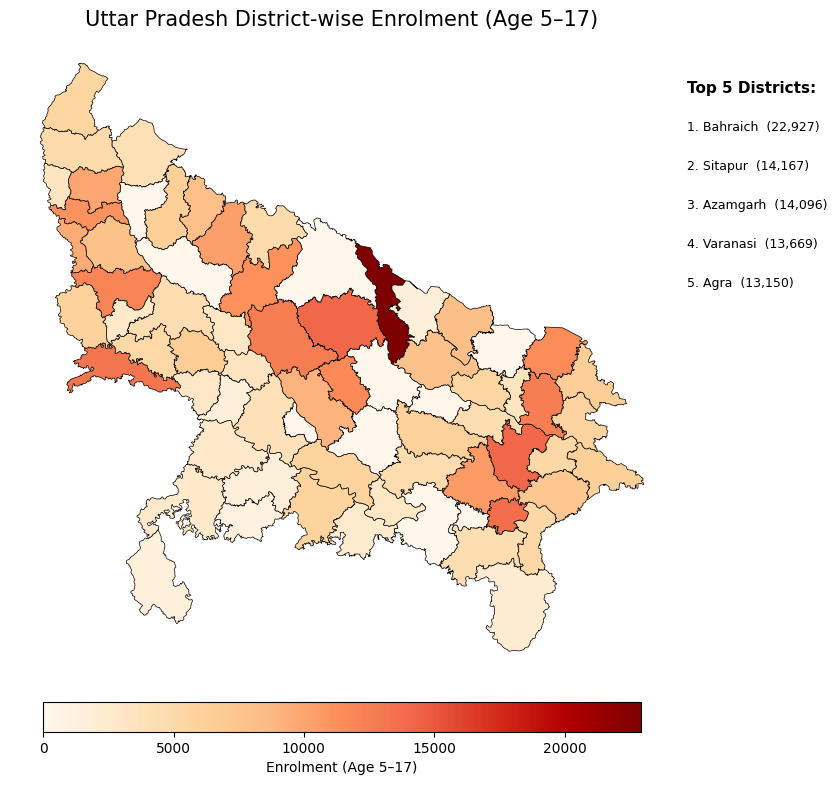

In [98]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12))

gdf.plot(
    ax=ax,
    column="enr_age_5_17",
    cmap="OrRd",          # light → dark
    linewidth=0.5,
    edgecolor="black",
    legend=True,
    legend_kwds={
    "label": "Enrolment (Age 5–17)",
    "orientation": "horizontal",
    "shrink": 0.9,
    "pad": 0.02
}
)

ax.set_title(
    "Uttar Pradesh District-wise Enrolment (Age 5–17)",
    fontsize=15
)
ax.axis("off")
x_pos = 1.02   # right of the map
y_start = 0.85
line_gap = 0.06

ax.text(
    x_pos, y_start + line_gap,
    "Top 5 Districts:",
    transform=ax.transAxes,
    fontsize=11,
    fontweight="bold",
    ha="left"
)

for i, row in top5_5_17.iterrows():
    ax.text(
        x_pos,
        y_start - i * line_gap,
        f"{i+1}. {row['NAME_2']}  ({int(row['enr_age_5_17']):,})",
        transform=ax.transAxes,
        fontsize=9,
        ha="left"
    )
plt.tight_layout(rect=[0, 0.08,0.85, 1])

plt.show()


In [99]:
bahraich_df = final_df[
    (final_df["state"] == "Uttar Pradesh") &
    (final_df["district"] == "Bahraich")
].copy()


In [100]:
import pandas as pd

bahraich_df["enr_age_5_17"] = pd.to_numeric(
    bahraich_df["enr_age_5_17"], errors="coerce"
).fillna(0)

pincode_enrol = (
    bahraich_df
    .groupby("pincode", as_index=False)["enr_age_5_17"]
    .sum()
)

# Ensure string for merge
pincode_enrol["pincode"] = pincode_enrol["pincode"].astype(str)

pincode_enrol


,pincode,enr_age_5_17
0,271801,2303.0
1,271802,324.0
2,271803,77.0
3,271821,123.0
4,271824,569.0
5,271825,1091.0
6,271830,1844.0
7,271831,0.0
8,271835,61.0
9,271840,4.0


In [101]:
# Ensure pincode column consistency
pin_code_gdf["Pincode"] = pin_code_gdf["Pincode"].astype(str).str.strip()

bahraich_gdf = pin_code_gdf.merge(
    pincode_enrol,
    left_on="Pincode",
    right_on="pincode",
    how="inner"
)


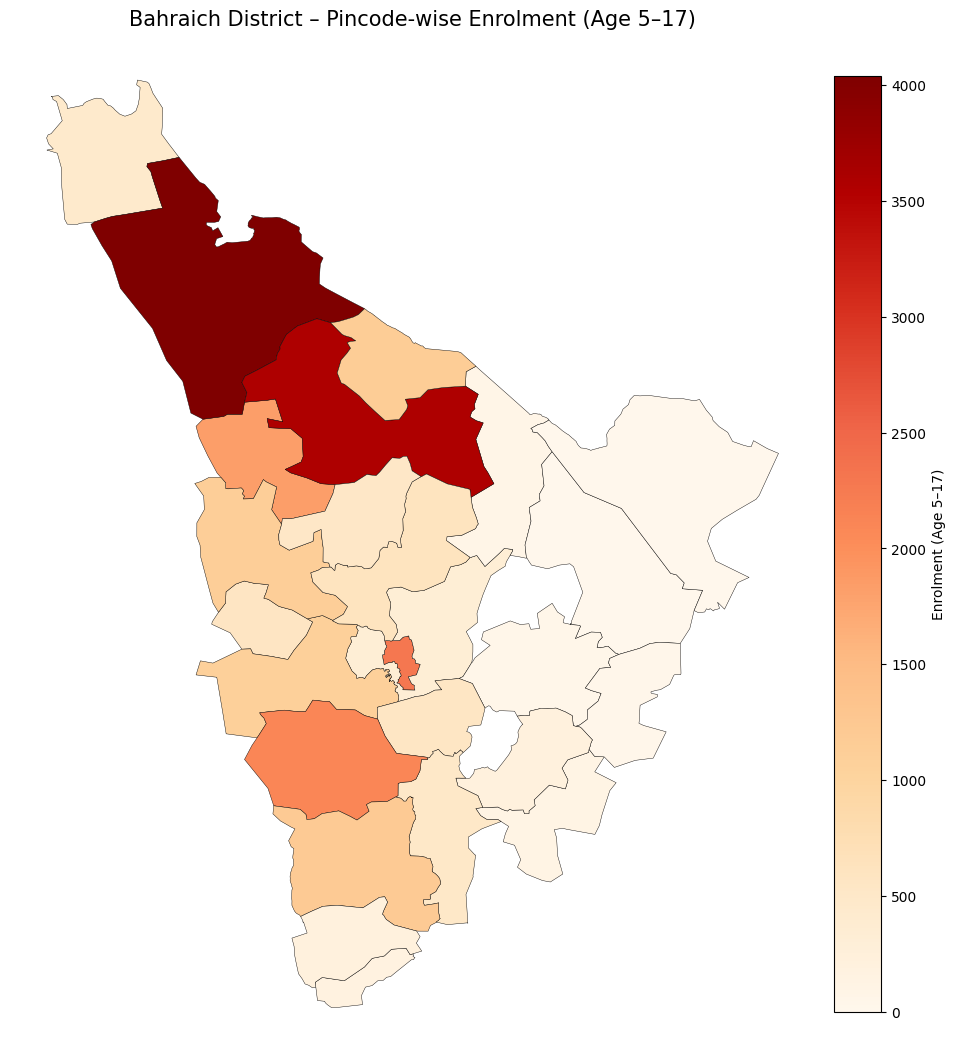

In [102]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12))

bahraich_gdf.plot(
    ax=ax,
    column="enr_age_5_17",
    cmap="OrRd",
    linewidth=0.3,
    edgecolor="black",
    legend=True,
    legend_kwds={
        "label": "Enrolment (Age 5–17)",
        "shrink": 0.8,
        "pad": 0.02
    }
)

ax.set_title(
    "Bahraich District – Pincode-wise Enrolment (Age 5–17)",
    fontsize=15
)
ax.axis("off")

plt.tight_layout()
plt.show()


In [103]:
bareilly_df_5_17 = final_df[
    (final_df["state"] == "Uttar Pradesh") &
    (final_df["district"] == "Bareilly")
].copy()


In [104]:
import pandas as pd

bareilly_df_5_17["enr_age_5_17"] = pd.to_numeric(
    bareilly_df_5_17["enr_age_5_17"], errors="coerce"
).fillna(0)

pincode_enrol = (
    bareilly_df_5_17
    .groupby("pincode", as_index=False)["enr_age_5_17"]
    .sum()
)

# Ensure string for merge
pincode_enrol["pincode"] = pincode_enrol["pincode"].astype(str)

pincode_enrol


,pincode,enr_age_5_17
0,243001,2005.0
1,243002,2.0
2,243003,259.0
3,243004,3.0
4,243005,287.0
5,243006,196.0
6,243122,412.0
7,243123,303.0
8,243201,1746.0
9,243202,381.0


In [105]:
pin_code_gdf["Pincode"] = pin_code_gdf["Pincode"].astype(str).str.strip()

bareilly_gdf_5_17 = pin_code_gdf.merge(
    pincode_enrol,
    left_on="Pincode",
    right_on="pincode",
    how="inner"
)

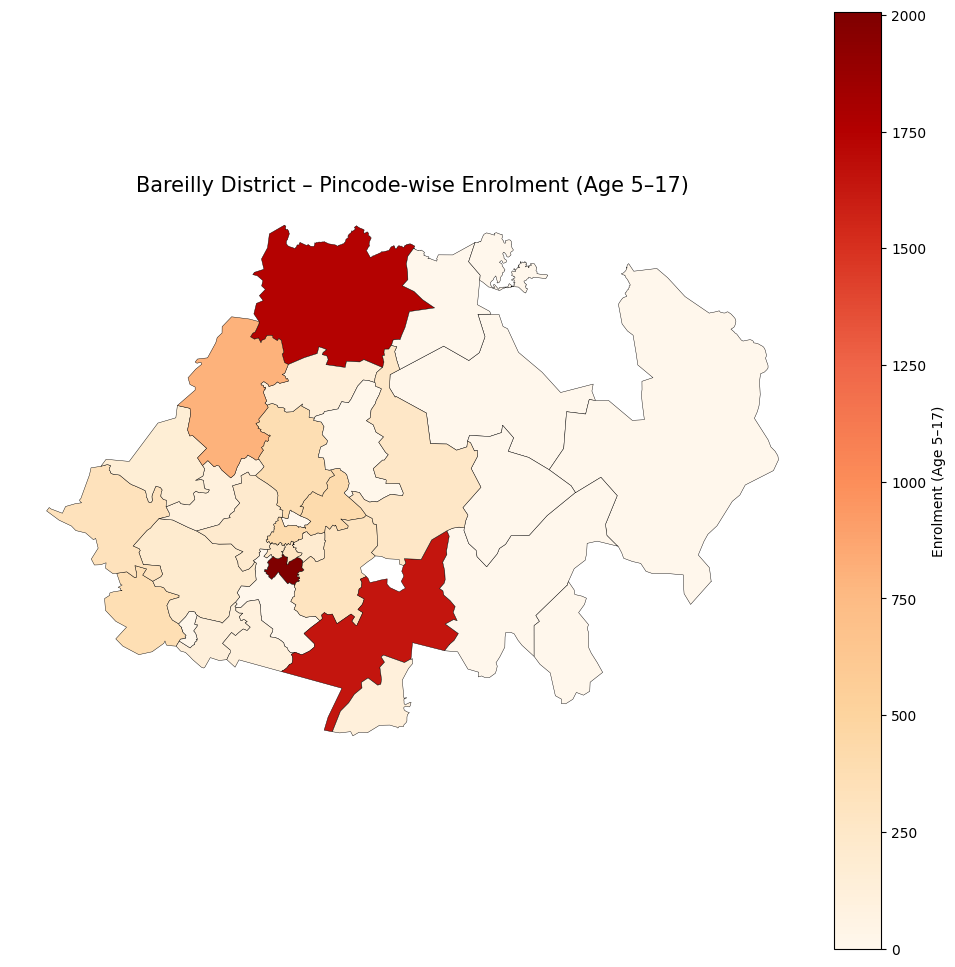

In [106]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12))

bareilly_gdf_5_17.plot(
    ax=ax,
    column="enr_age_5_17",
    cmap="OrRd",
    linewidth=0.3,
    edgecolor="black",
    legend=True,
    legend_kwds={
        "label": "Enrolment (Age 5–17)",
        "shrink": 0.8,
        "pad": 0.02
    }
)

ax.set_title(
    "Bareilly District – Pincode-wise Enrolment (Age 5–17)",
    fontsize=15
)
ax.axis("off")

plt.tight_layout()
plt.show()


# 18+ Enrolment

In [89]:
top_18_ = (
    state_enrol
    .sort_values("enr_age_18_greater", ascending=False)
    .head(5)
)
top_18_

,state,enr_age_0_5,enr_age_5_17,enr_age_18_greater
22,Meghalaya,21297.0,53297.0,34909.0
3,Assam,132549.0,61352.0,20203.0
33,Uttar Pradesh,509959.0,469808.0,17851.0
10,Gujarat,151663.0,45628.0,12214.0
4,Bihar,260253.0,321636.0,10689.0


In [90]:
india_states["state_norm"] = (
    india_states["NAME_1"]
    .str.lower()
    .str.replace("&", "and")
    .str.replace(" islands", "", regex=False)
    .str.strip()
)

top_18_["state_norm"] = (
    top_18_["state"]
    .str.lower()
    .str.replace("&", "and")
    .str.replace(" islands", "", regex=False)
    .str.strip()
)

In [92]:
top_states_geo_18_ = india_states[
    india_states["state_norm"].isin(top_18_["state_norm"])
]
top_states_geo_18_[["NAME_1", "state_norm"]]



,NAME_1,state_norm
3,Assam,assam
4,Bihar,bihar
11,Gujarat,gujarat
22,Meghalaya,meghalaya
32,Uttar Pradesh,uttar pradesh


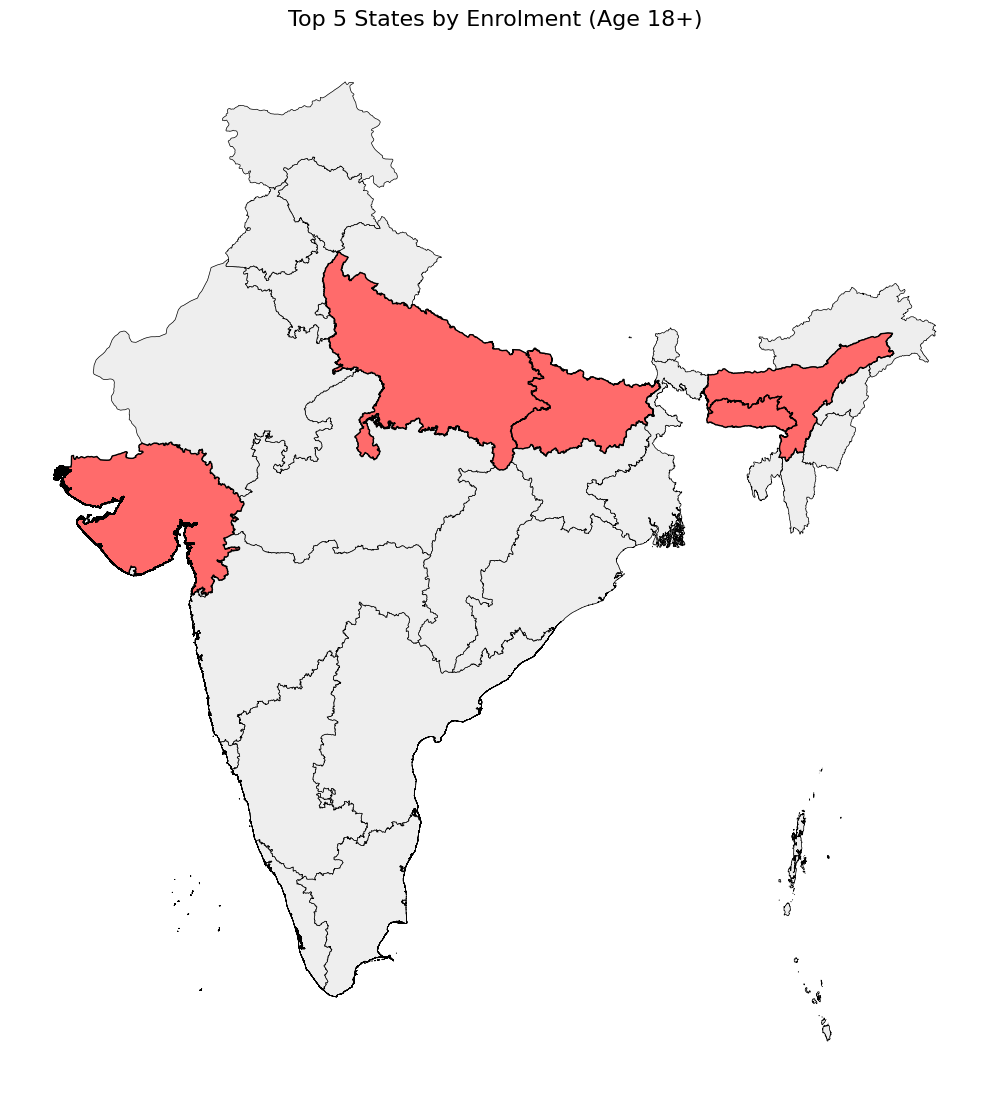

In [93]:
fig, ax = plt.subplots(figsize=(10, 12))

# Plot all states in light grey
india_states.plot(
    ax=ax,
    color="#eeeeee",
    edgecolor="black",
    linewidth=0.5
)

# Highlight top 5 states
top_states_geo_18_.plot(
    ax=ax,
    color="#ff6b6b",
    edgecolor="black",
    linewidth=1
)

ax.set_title("Top 5 States by Enrolment (Age 18+)", fontsize=16)
ax.axis("off")

plt.tight_layout()
plt.show()


# Uttar Pradesh Enrolment Status 18+

In [107]:
top_districts_18_ = (
    up_df
    .groupby("district", as_index=False)["enr_age_18_greater"]
    .sum()
    .sort_values("enr_age_18_greater", ascending=False)
)

top_districts_18_

,district,enr_age_18_greater
9,Bahraich,2358.0
0,Agra,912.0
70,Sitapur,792.0
42,Kanpur Nagar,698.0
28,Gautam Buddha Nagar,645.0
...,...,...
71,Sonbhadra,13.0
50,Mahoba,12.0
55,Mirzapur,10.0
16,Bhadohi,5.0


In [108]:
def normalize_district(s):
    return (
        s.lower()
        .replace("&", "and")
        .replace(".", "")
        .replace(" district", "")
        .strip()
    )

up_districts_gdf["district_norm"] = (
    up_districts_gdf["NAME_2"].apply(normalize_district)
)

top_districts_18_["district_norm"] = (
    top_districts_18_["district"].apply(normalize_district)
)

In [110]:
gdf = up_districts_gdf.merge(
    top_districts_18_,
    on="district_norm",
    how="left"
)

# Replace NaN enrolment with 0
gdf["enr_age_18_greater"] = gdf["enr_age_18_greater"].fillna(0)


In [111]:
top5_18 = (
    gdf[["NAME_2", "enr_age_18_greater"]]
    .sort_values("enr_age_18_greater", ascending=False)
    .head(5)
    .reset_index(drop=True)
)

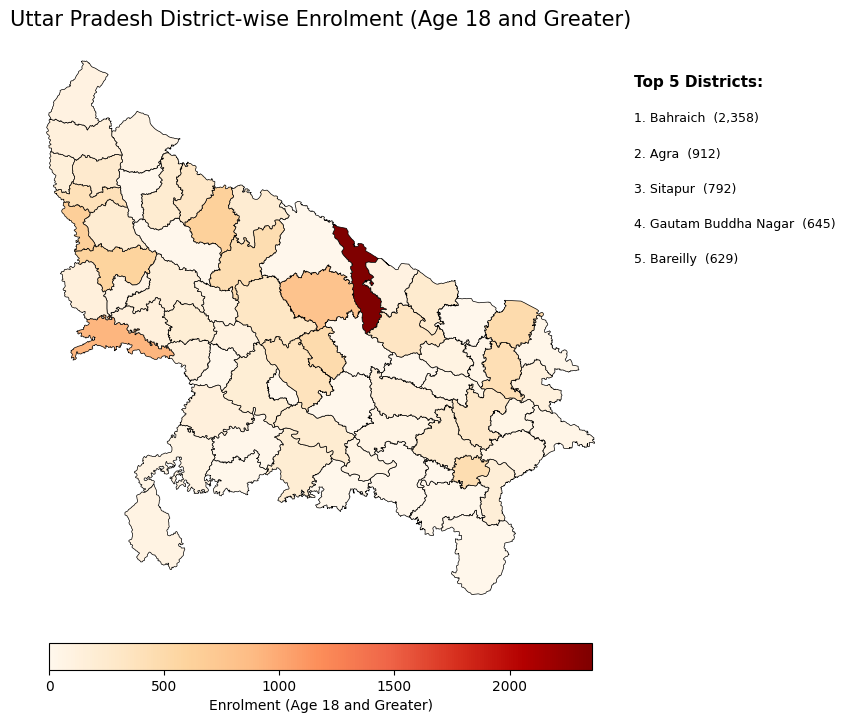

In [112]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12))

gdf.plot(
    ax=ax,
    column="enr_age_18_greater",
    cmap="OrRd",          # light → dark
    linewidth=0.5,
    edgecolor="black",
    legend=True,
    legend_kwds={
    "label": "Enrolment (Age 18 and Greater)",
    "orientation": "horizontal",
    "shrink": 0.9,
    "pad": 0.02
}
)

ax.set_title(
    "Uttar Pradesh District-wise Enrolment (Age 18 and Greater)",
    fontsize=15
)
ax.axis("off")
x_pos = 1.02   # right of the map
y_start = 0.85
line_gap = 0.06

ax.text(
    x_pos, y_start + line_gap,
    "Top 5 Districts:",
    transform=ax.transAxes,
    fontsize=11,
    fontweight="bold",
    ha="left"
)

for i, row in top5_18.iterrows():
    ax.text(
        x_pos,
        y_start - i * line_gap,
        f"{i+1}. {row['NAME_2']}  ({int(row['enr_age_18_greater']):,})",
        transform=ax.transAxes,
        fontsize=9,
        ha="left"
    )
plt.tight_layout(rect=[0, 0.08,0.85, 1])

plt.show()


In [113]:
bahraich_df_18 = final_df[
    (final_df["state"] == "Uttar Pradesh") &
    (final_df["district"] == "Bahraich")
].copy()

In [115]:
import pandas as pd

bahraich_df_18["enr_age_18_greater"] = pd.to_numeric(
    bahraich_df_18["enr_age_18_greater"], errors="coerce"
).fillna(0)

pincode_enrol_18 = (
    bahraich_df_18
    .groupby("pincode", as_index=False)["enr_age_18_greater"]
    .sum()
)

# Ensure string for merge
pincode_enrol_18["pincode"] = pincode_enrol_18["pincode"].astype(str)

pincode_enrol_18

,pincode,enr_age_18_greater
0,271801,181.0
1,271802,18.0
2,271803,13.0
3,271821,18.0
4,271824,48.0
5,271825,98.0
6,271830,225.0
7,271831,0.0
8,271835,2.0
9,271840,0.0


In [116]:
# Ensure pincode column consistency
pin_code_gdf["Pincode"] = pin_code_gdf["Pincode"].astype(str).str.strip()

bahraich_gdf_18 = pin_code_gdf.merge(
    pincode_enrol_18,
    left_on="Pincode",
    right_on="pincode",
    how="inner"
)


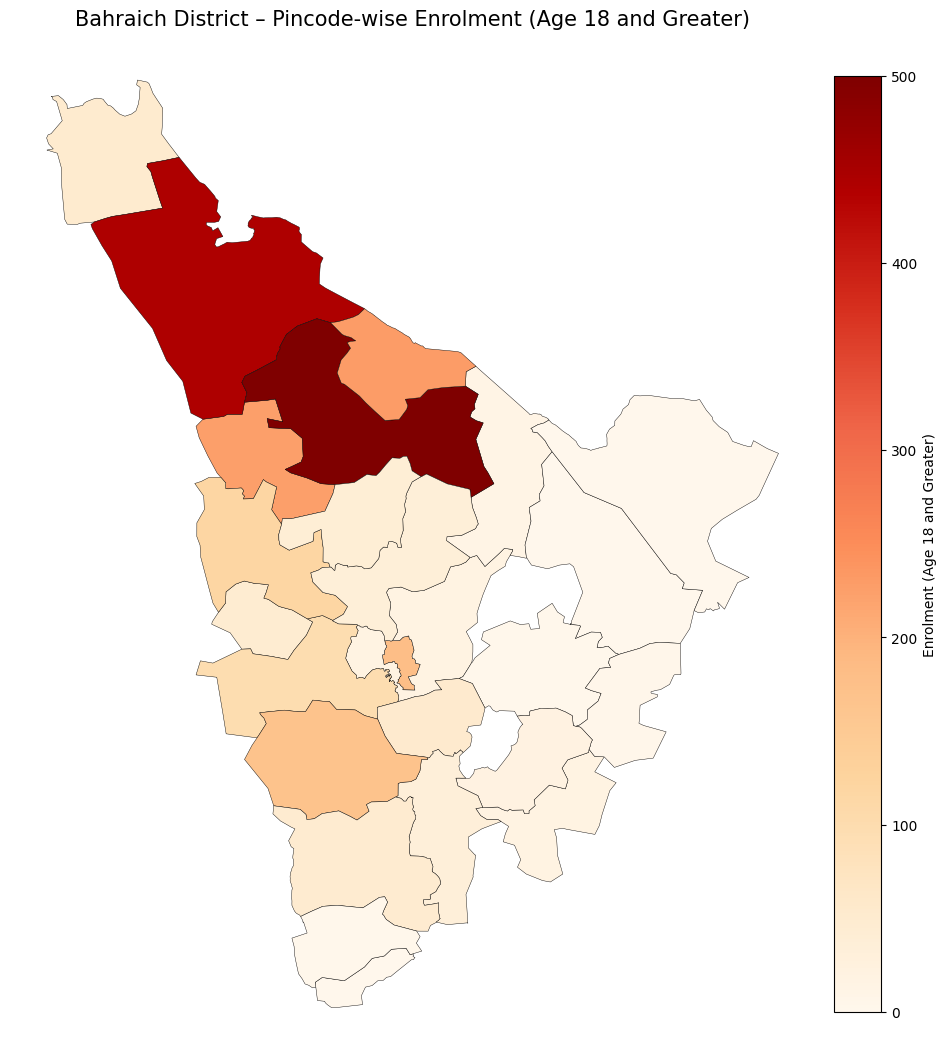

In [117]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12))

bahraich_gdf_18.plot(
    ax=ax,
    column="enr_age_18_greater",
    cmap="OrRd",
    linewidth=0.3,
    edgecolor="black",
    legend=True,
    legend_kwds={
        "label": "Enrolment (Age 18 and Greater)",
        "shrink": 0.8,
        "pad": 0.02
    }
)

ax.set_title(
    "Bahraich District – Pincode-wise Enrolment (Age 18 and Greater)",
    fontsize=15
)
ax.axis("off")

plt.tight_layout()
plt.show()


# Meghalaya Enrolment Status